# MC Moves with VAEs

This notebook will cover training of a VAE and then its use as a proposal probability distribution for Markov Chain Monte Carlo moves.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import vaemolsim

import matplotlib.pyplot as plt

## Creating training data

First, we will create some training data. For this, we will use TensorFlow Probability to come up with a 2D distribution that we will project down to 1D, then decode back.

In [2]:
data_dist = tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=[0.7, 0.2, 0.1]),
                                      components=[tfp.distributions.Independent(tfp.distributions.Normal(loc=[-0.5, 0.0], scale=[0.05, 0.5]),
                                                                               reinterpreted_batch_ndims=1),
                                                  tfp.distributions.Independent(tfp.distributions.Normal(loc=[1.0, 2.0], scale=[1.0, 0.5]),
                                                                               reinterpreted_batch_ndims=1),
                                                  tfp.distributions.Independent(tfp.distributions.Normal(loc=[-1.5, 0.0], scale=[0.5, 0.2]),
                                                                               reinterpreted_batch_ndims=1),
                                                 ],
                                     )

In [3]:
data_sample = data_dist.sample(10000).numpy()

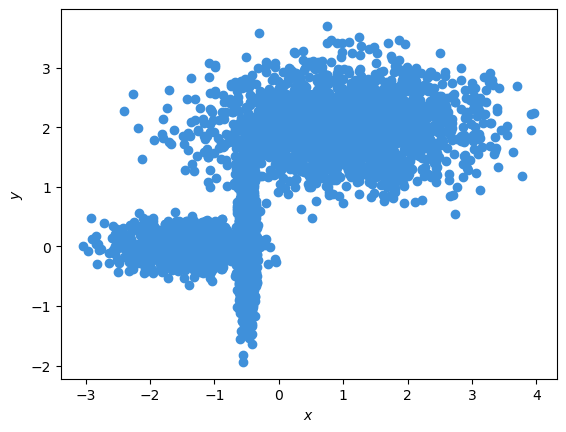

In [4]:
fig, ax = plt.subplots()
ax.scatter(data_sample[:, 0], data_sample[:, 1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

## Training a simple VAE

A VAE is fully specified by 1) an encoding probability model, 2) a decoding probability model, and 3) a prior probability model. The specific choice of decoding model will dictate the reconstruction loss, while the form of the encoder and prior will dictate the form of the regularization loss. Once we have a VAE trained, we can use it to propose global transitions of our system that can be made to satisfy detailed balance via [VAE-based MC moves](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.2c00110).

Start with creating an encoding distribution.

In [5]:
encoder_dist = tfp.layers.IndependentNormal(1) # Projects down to 1 dimension
encoder = vaemolsim.models.MappingToDistribution(encoder_dist, name='encoder')

In [6]:
encoder(data_sample)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[10000] event_shape=[1] dtype=float32>

Next, we can define a prior. To increase the flexibility of our prior, we will learn it using a flowed distribution starting from a standard normal.

In [7]:
prior_flow = vaemolsim.flows.RQSSplineMAF(
    num_blocks=4, # Number of transformation blocks
    # The below dictionary of parameters defines aspects of the neural rational quadratic splines
    rqs_params={'bin_range': [-10.0, 10.0], # List of min and max values for transformation - data outside this range will NOT be transformed!
                'num_bins': 20, # Number of bins - more is a more powerful transformation but is more expensive
                'hidden_dim': 40, # Number of hidden dimensions in neural networks (should be more than num_bins, ideally)
               }, 
)
_ = prior_flow(np.random.random((2, 1))) # Pass any data of right shape through flow to build it right
prior_latent = tfp.layers.DistributionLambda(make_distribution_fn=lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros((tf.shape(t)[0], 1)),
                                                                                                                                   scale=tf.ones((tf.shape(t)[0], 1))),
                                                                                                                reinterpreted_batch_ndims=1)
                                                   )
prior_dist = vaemolsim.dists.FlowedDistribution(prior_flow, prior_latent, name='prior')

In [8]:
prior_dist(np.random.random((2, 1)))

<tfp.distributions._TransformedDistribution 'chain_of_block_3_of_block_2_of_block_1_of_block_0tensor_coercible' batch_shape=[2] event_shape=[1] dtype=float32>

Finally, we can build a decoding model. We will choose an independent set of normal distributions.

In [9]:
decoder_dist = vaemolsim.dists.AutoregressiveBlockwise(
    2, # Number of degrees of freedom
    [tfp.distributions.Normal,]*2, # CLASS for each probability distribution on each degree of freedom
    conditional=True, # Will take conditional inputs, specifically the CG coordinate
    conditional_event_shape=(1,), # Dimensionality of the CG coordinate
    auto_net_params={'hidden_units': [10, 100, 10]}, # Adjust depth of autoregressive network
)
decoder = vaemolsim.models.MappingToDistribution(decoder_dist, name='decoder')

In [10]:
decoder(np.random.random((2, 1)))

<tfp.distributions.Autoregressive 'Autoregressive' batch_shape=? event_shape=? dtype=float32>

Put it all together in a VAE model!

In [11]:
vae = vaemolsim.models.VAE(encoder, decoder, prior_dist)

In [12]:
vae(data_sample[:10, :])

<tfp.distributions.Autoregressive 'Autoregressive' batch_shape=? event_shape=? dtype=float32>

In [13]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (MappingToDistribu  multiple                  1002      
 tion)                                                           
                                                                 
 decoder (MappingToDistribu  multiple                  3512      
 tion)                                                           
                                                                 
 prior (FlowedDistribution)  multiple                  10636     
                                                                 
Total params: 15150 (59.18 KB)
Trainable params: 15150 (59.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile and train! Note that during fit, the inputs and targets are the same things.

In [14]:
vae.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=vaemolsim.losses.LogProbLoss())

In [15]:
vae.fit(data_sample, data_sample, epochs=50)

Epoch 1/50
313/313 [==============================] - 10s 3ms/step - loss: 2.1650 - kl_div: 0.5192 - regularizer_loss: 0.5192
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 1.5260 - kl_div: 0.9572 - regularizer_loss: 0.9572
Epoch 3/50
313/313 [==============================] - 1s 4ms/step - loss: 1.0803 - kl_div: 1.1783 - regularizer_loss: 1.1783
Epoch 4/50
313/313 [==============================] - 1s 3ms/step - loss: 0.9682 - kl_div: 1.2569 - regularizer_loss: 1.2569
Epoch 5/50
313/313 [==============================] - 1s 4ms/step - loss: 0.9190 - kl_div: 1.2705 - regularizer_loss: 1.2705
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 0.9093 - kl_div: 1.3057 - regularizer_loss: 1.3057
Epoch 7/50
313/313 [==============================] - 1s 4ms/step - loss: 0.9011 - kl_div: 1.2945 - regularizer_loss: 1.2945
Epoch 8/50
313/313 [==============================] - 1s 3ms/step - loss: 0.8933 - kl_div: 1.2953 - regularizer_loss: 1.2953

Check out our learned encoding.

In [16]:
model_encoder_sample = vae.encoder(data_sample).sample()

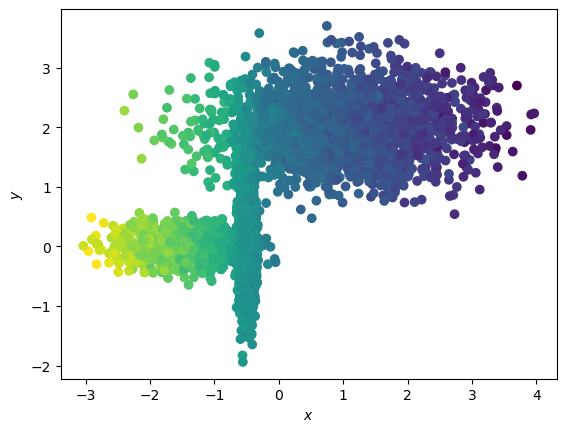

In [17]:
fig, ax = plt.subplots()
ax.scatter(data_sample[:, 0], data_sample[:, 1], c=np.squeeze(model_encoder_sample))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

Now check if we have learned an appropriate prior model on the latent space.

In [18]:
model_latent_sample = vae.prior(np.ones((10000, 1))).sample()

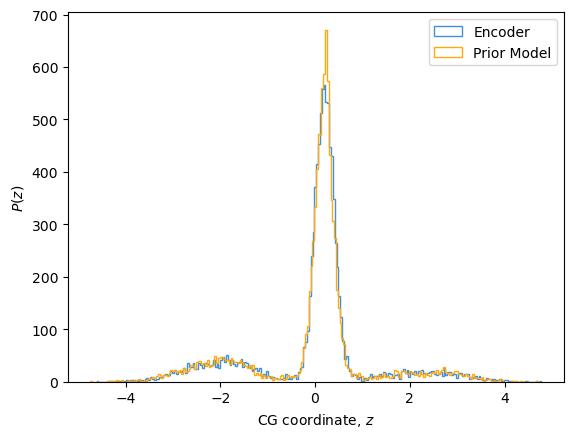

In [19]:
fig, ax = plt.subplots()
_ = ax.hist(np.squeeze(model_encoder_sample), bins='auto', histtype='step', label='Encoder')
_ = ax.hist(np.squeeze(model_latent_sample), bins='auto', histtype='step', label='Prior Model')
ax.set_xlabel(r'CG coordinate, $z$')
ax.set_ylabel(r'$P(z)$')
ax.legend()
plt.show()

Not bad! Now let's check the decoding model in both reconstruction and decoding modes.

In [20]:
recon_sample = vae(data_sample).sample()
gen_sample = vae.decoder(model_latent_sample).sample()

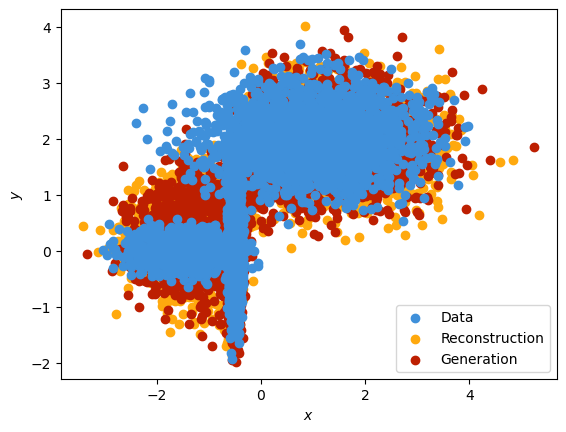

In [21]:
fig, ax = plt.subplots()
ax.scatter(data_sample[:, 0], data_sample[:, 1], label='Data', zorder=10)
ax.scatter(recon_sample[:, 0], recon_sample[:, 1], label='Reconstruction')
ax.scatter(gen_sample[:, 0], gen_sample[:, 1], label='Generation')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()
plt.show()

It's pretty good, but not perfect. That's ok, though.  We can correct it with VAE-based MC sampling, shown next.

## VAE-based MC Sampling

We first construct an MCMC object, using the negative log-probability of the data as the energy function, though we wrap this to produce numpy outputs.

In [22]:
def data_energy(configs):
    return data_dist.log_prob(configs).numpy()

In [23]:
mc_sim = vaemolsim.mcmc.MCMC(vae, data_energy)

Run 10000 MCMC simulations in parallel for 100 steps, then look at the distribution. Note that we've started from the true distribution samples.

In [28]:
mc_sample, mc_energies = mc_sim.run(data_sample, n_steps=100)

Check the acceptance rate to make sure it's actually sampling and not just stuck.

In [29]:
print(mc_sim.acceptance_rate)

0.7739621076233184


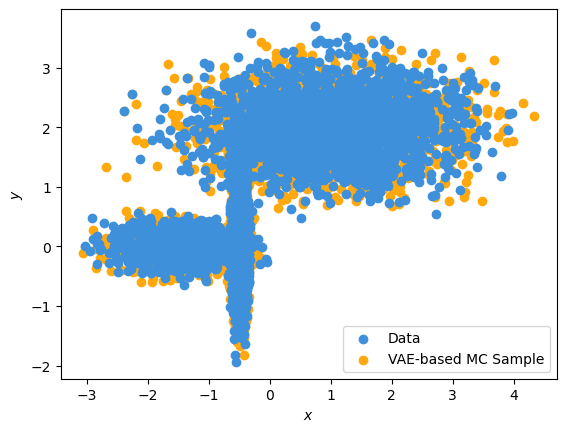

In [30]:
fig, ax = plt.subplots()
ax.scatter(data_sample[:, 0], data_sample[:, 1], label='Data', zorder=10)
ax.scatter(mc_sample[:, 0], mc_sample[:, 1], label='VAE-based MC Sample')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()
plt.show()